In [142]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
from glob import glob
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt, spectrogram
import seaborn as sns
import xarray as xr
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.transforms as mtrans

from filtering import freq_filt
from cb91visuals import *
sns.set(font='sans-serif',
        rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'font.family':'Arial',
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

In [2]:
data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'

with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

/tmp/ipykernel_27448/768055115.py:69: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)


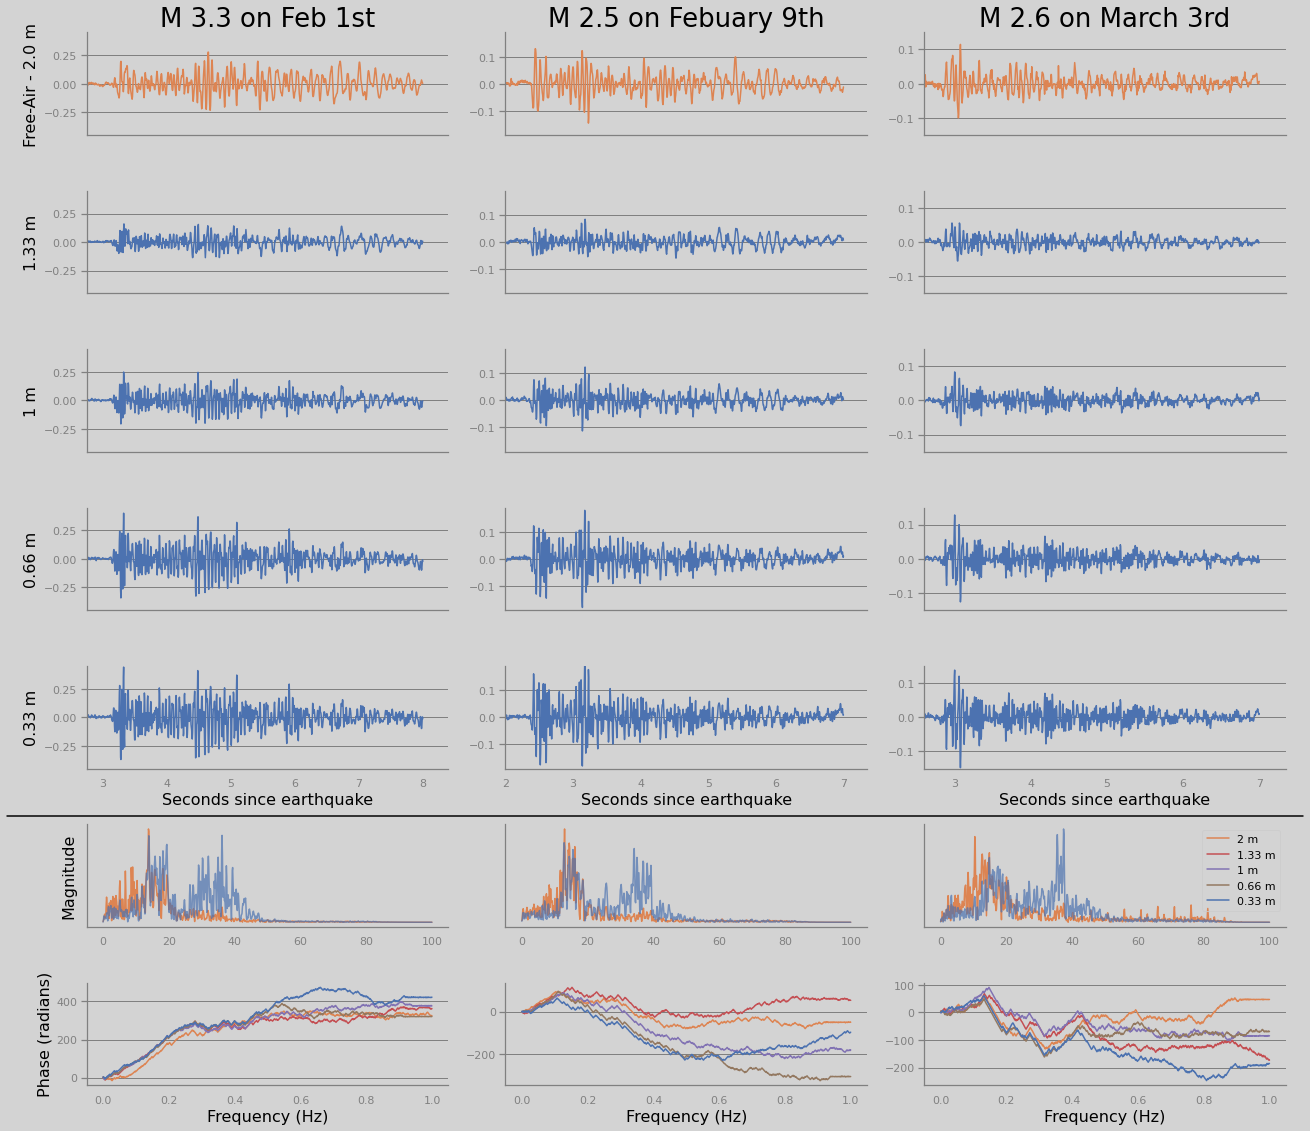

In [183]:
hs = [2, 1.33, 1, 0.66, 0.33]
eqs = {0: {'day':'2022-02-01','hour': 9,'smin': 43,'ssec': 6.590,'emin': 43,'esec': 15,'ylim': 0.45, 'id': 'us7000ggx4', 'title':'M 3.3 on Feb 1st'},\
    1: {'day':'2022-02-09','hour': 9,'smin': 56,'ssec': 27.412,'emin': 56,'esec': 34.5,'ylim': 0.19, 'id': 'us7000gjaw', 'title': 'M 2.5 on Febuary 9th'},\
    2: {'day':'2022-03-03','hour': 15,'smin': 17,'ssec': 22.106,'emin': 17,'esec': 30,'ylim': 0.15, 'id': 'us6000h1ql', 'title':'M 2.6 on March 3rd'}}

f, axes = plt.subplots(7, len(eqs), figsize = (18,16))
for i, eq_d in eqs.items():
    locals().update(eq_d)
    s = f'{day} T{hour}:{smin}:{ssec}'
    e = f'{day} T{hour}:{emin}:{esec}'
    t_delta = pd.to_datetime(e) - pd.to_datetime(s)
    for j, h in enumerate(hs):
        ax = axes[j, i]
        da = pd.read_parquet(days[day][h])
        hour = 9
        sub = da.loc[(da.index > s) & (da.index < e), 'pa']
        ser = pd.Series(freq_filt(sub.values, 1, 'highpass', 1), np.linspace(0, t_delta.seconds, len(sub)))
        win = np.hamming(len(ser))
        if h == 2:
            sns.lineplot(data = ser, ax = ax, color = 'C1')
        else:
            sns.lineplot(data = ser, ax = ax)
        if i == 0:
            if j != 0:
                ax.set_ylabel(f'{h} m')
            else:
                ax.set_ylabel('Free-Air - 2.0 m')
        if j == 0:
            ax.set_title(title)
        if j != 4:
            ax.set_xticks([])
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Seconds since earthquake')
        ax.set_ylim(-ylim, ylim)
        if i == 0:
            ax.set_xlim(left = 2.75)
        elif i == 2:
            ax.set_xlim(left = 2.6)
        else:
            ax.set_xlim(left = 2)
        if h == 0.33:
            axes[5, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C0', alpha = 0.7) 
            axes[6,i].phase_spectrum(ser, label = f'{h} m', color = 'C0', window = win)

        elif h == 2:
            axes[5, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C1')
            axes[6,i].phase_spectrum(ser, label = f'{h} m', color = 'C1', window = win)
        else:
            axes[6,i].phase_spectrum(ser, label = f'{h} m', color = f'C{j+2}', window = win)
            # axes[5, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C2', alpha = 0.7) 
    if i != 0:
        axes[5, i].set_ylabel('')
        axes[6, i].set_ylabel('')
    else:
        axes[5,i].set_ylabel('Magnitude')
    if i == 2:
        handles, labels = axes[6,2].get_legend_handles_labels()
        axes[5,2].legend(handles, labels, loc='best')
    axes[5,i].set_yticks([])
    axes[5,i].set_xlabel('')
    axes[6,i].set_xlabel('Frequency (Hz)')
plt.tight_layout()


# Get the bounding boxes of the axes including text decorations
r = f.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(f.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for k, y in enumerate(ys):
    if k == 4:
        line = plt.Line2D([0,1],[y,y], transform=f.transFigure, color="black")
        f.add_artist(line)

fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
plt.savefig(join(fig_dir, 'signal_compares', 'multieq_example_v3.png'), dpi = 300)

/tmp/ipykernel_27448/959812537.py:88: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)


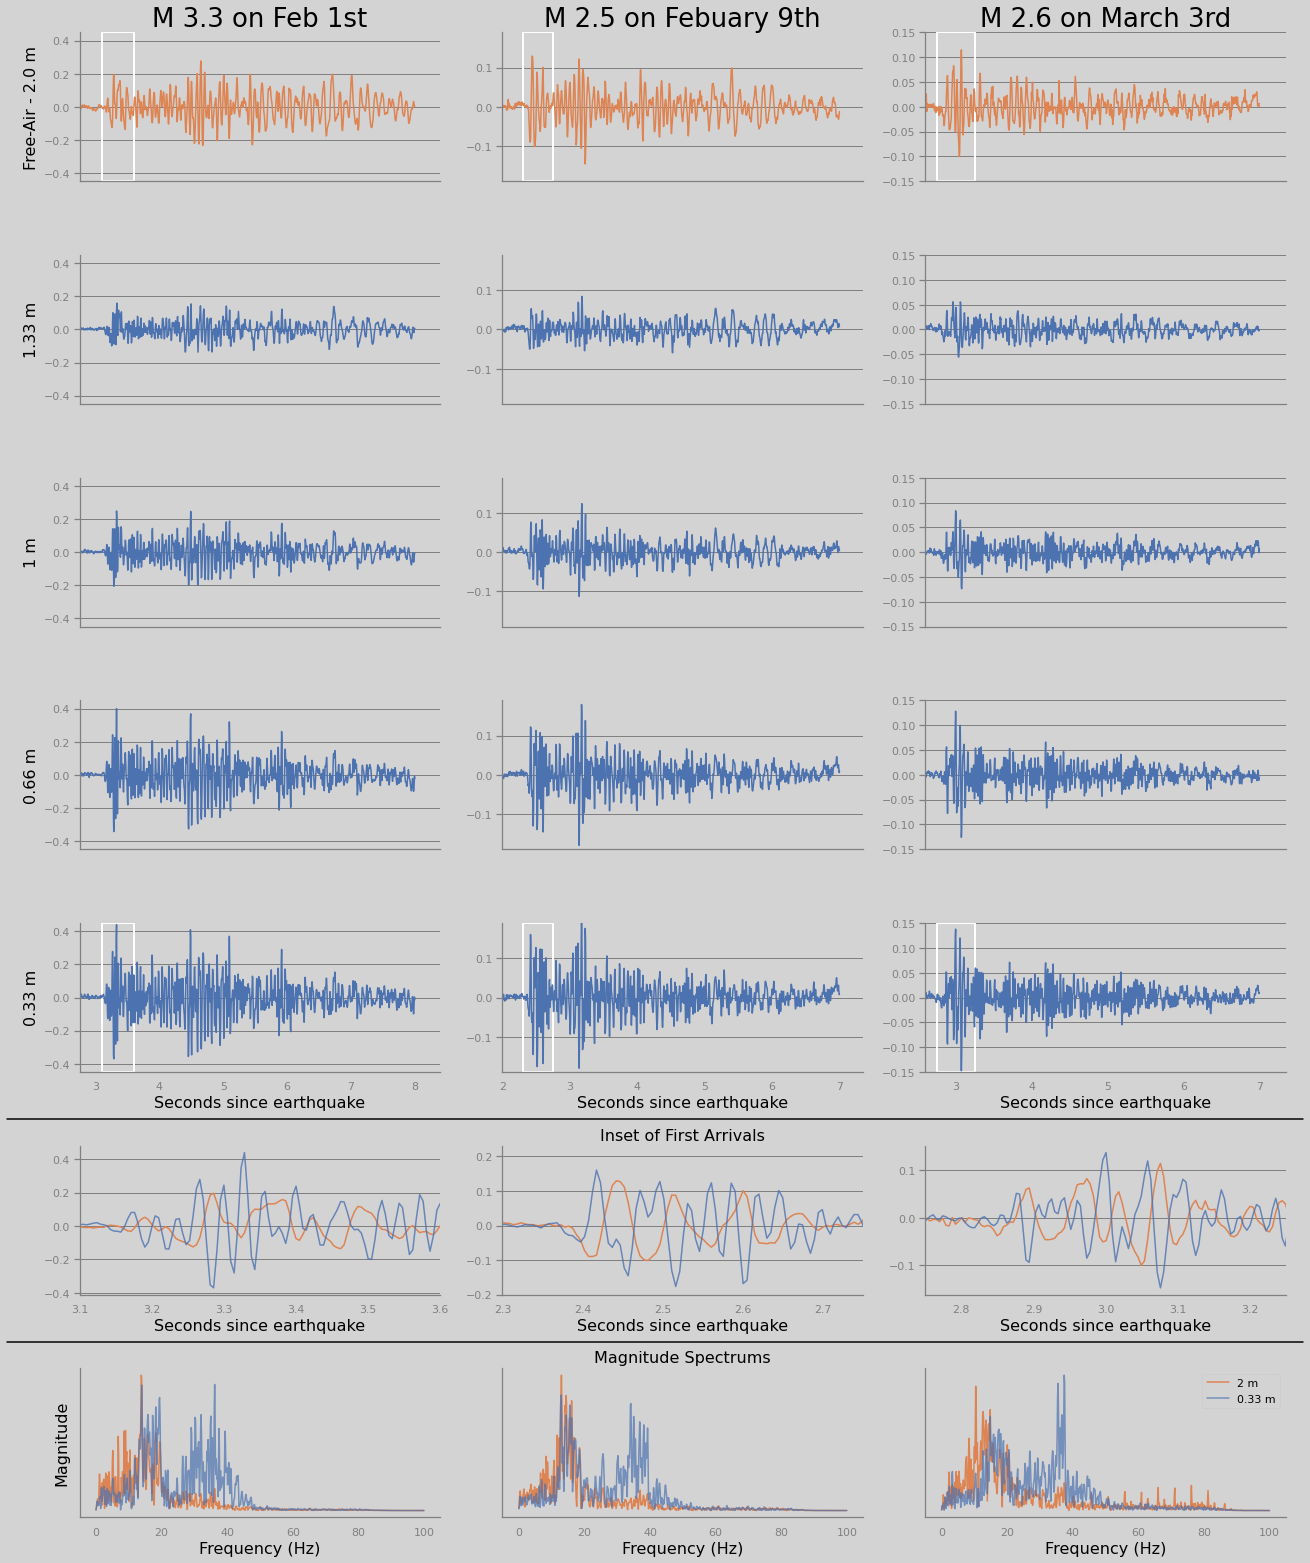

In [207]:
hs = [2, 1.33, 1, 0.66, 0.33]
eqs = {0: {'day':'2022-02-01','hour': 9,'smin': 43,'ssec': 6.590,'emin': 43,'esec': 15,'ylim': 0.45, 'id': 'us7000ggx4', 'title':'M 3.3 on Feb 1st'},\
    1: {'day':'2022-02-09','hour': 9,'smin': 56,'ssec': 27.412,'emin': 56,'esec': 34.5,'ylim': 0.19, 'id': 'us7000gjaw', 'title': 'M 2.5 on Febuary 9th'},\
    2: {'day':'2022-03-03','hour': 15,'smin': 17,'ssec': 22.106,'emin': 17,'esec': 30,'ylim': 0.15, 'id': 'us6000h1ql', 'title':'M 2.6 on March 3rd'}}

f, axes = plt.subplots(7, len(eqs), figsize = (18,22))
for i, eq_d in eqs.items():
    locals().update(eq_d)
    s = f'{day} T{hour}:{smin}:{ssec}'
    e = f'{day} T{hour}:{emin}:{esec}'
    t_delta = pd.to_datetime(e) - pd.to_datetime(s)
    for j, h in enumerate(hs):
        ax = axes[j, i]
        da = pd.read_parquet(days[day][h])
        hour = 9
        sub = da.loc[(da.index > s) & (da.index < e), 'pa']
        ser = pd.Series(freq_filt(sub.values, 1, 'highpass', 1), np.linspace(0, t_delta.seconds, len(sub)))
        win = np.hamming(len(ser))
        if h == 2:
            sns.lineplot(data = ser, ax = ax, color = 'C1')
            sns.lineplot(data = ser, ax = axes[5, i], color = 'C1')
        else:
            sns.lineplot(data = ser, ax = ax)
            if h == 0.33:
                sns.lineplot(data = ser, ax = axes[5, i], color = 'C0', alpha = 0.8)
        if i == 0:
            if j != 0:
                ax.set_ylabel(f'{h} m')
            else:
                ax.set_ylabel('Free-Air - 2.0 m')
        if j == 0:
            ax.set_title(title)
        if j != 4:
            ax.set_xticks([])
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Seconds since earthquake')
        ax.set_ylim(-ylim, ylim)
        if i == 0:
            ax.set_xlim(left = 2.75)
        elif i == 2:
            ax.set_xlim(left = 2.6)
        else:
            ax.set_xlim(left = 2)
        if h == 0.33:
            axes[6, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C0', alpha = 0.7) 

        elif h == 2:
            axes[6, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C1')
        else:
            pass
            # axes[5, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C2', alpha = 0.7) 
    if i != 0:
        axes[6, i].set_ylabel('')
    else:
        axes[6,i].set_ylabel('Magnitude')
    if i == 2:
        handles, labels = axes[6,2].get_legend_handles_labels()
        axes[6,2].legend(handles, labels, loc='best')
    axes[6,1].set_title('Magnitude Spectrums', fontsize = 16)
    axes[6,i].set_yticks([])
    axes[6,i].set_xlabel('Frequency (Hz)')
    axes[5,1].set_title('Inset of First Arrivals', fontsize = 16)
    axes[5,i].set_xlabel('Seconds since earthquake')
    if i == 0:
        ts = (3.1,3.6)
        for l in [0,4]:
            axes[l, i].add_patch(mpl.patches.Rectangle((ts[0],-ylim), (ts[1]-ts[0]), 2*ylim, facecolor="None", edgecolor = 'white', linewidth = 2))
        axes[5,i].set_xlim(ts)
    elif i == 1:
        ts = (2.3,2.75)
        for l in [0,4]:
            axes[l, i].add_patch(mpl.patches.Rectangle((ts[0],-ylim), (ts[1]-ts[0]), 2*ylim, facecolor="None", edgecolor = 'white', linewidth = 2))
        axes[5,i].set_xlim(ts)
    else:
        ts = (2.75,3.25)
        for l in [0,4]:
            axes[l, i].add_patch(mpl.patches.Rectangle((ts[0],-ylim), (ts[1]-ts[0]), 2*ylim, facecolor="None", edgecolor = 'white', linewidth = 2))
        axes[5,i].set_xlim(ts)

    
plt.tight_layout()


# Get the bounding boxes of the axes including text decorations
r = f.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(f.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for k, y in enumerate(ys):
    if k == 4 or k == 5:
        line = plt.Line2D([0,1],[y,y], transform=f.transFigure, color="black")
        f.add_artist(line)

fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
plt.savefig(join(fig_dir, 'signal_compares', 'multieq_example_v4.png'), dpi = 300)